# 3.2 线性回归从0开始实现

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 3.2.1 生成数据集

### torch.normal(0, 1, (a, b))
创建一个张量为[a,b]维度，mean=1，var=1
### torch.matmul() tensor的乘法
输入可以是高维的
### reshape((-1, 1))
numpy中reshape函数的三种常见相关用法
reshape(1,-1)转化成1行：

reshape(2,-1)转换成两行：

reshape(-1,1)转换成1列：

reshape(-1,2)转化成两列

In [4]:
# features中的每一行都包含一个二维数据样本，torch.Size([1000, 2]),
# labels中的每一行都包含一维标签值（一个标量）,torch.Size([1000, 1]),
# true_w 的 torch.Size([2])
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.5705, -1.9762]) 
label: tensor([9.7763])


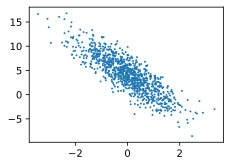

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 3.2.2 读取数据集

### list:列出数值
### random.shuffle():打乱数据
### range(start,end,step)
### <span class="burk">yield()</span>

In [9]:
# data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。
# 每个小批量包含一组特征和标签。

# len(features)=1000
# indices:列出1-1000的数字，list
# random.shuffle(indices)打乱顺序
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    # 读取打乱顺序之后的值
    # 将1000个数据，划分为100个小批量，每个小批量10个数据
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]



In [10]:
# 读取第一个小批量数据样本并打印。
# 每个批量的特征维度说明了批量大小和输入特征数
# 为什么可以只打印第一个小批量数据 因为break
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break


tensor([[-2.5080, -1.0362],
        [ 0.3272,  1.9318],
        [ 0.2047,  0.0111],
        [-1.2922,  1.4446],
        [-0.2214,  0.3989],
        [ 0.7122, -0.3655],
        [ 0.6120, -1.0852],
        [ 0.7069,  0.5515],
        [-1.5065,  1.2637],
        [ 0.0037, -0.0402]]) 
 tensor([[ 2.7183],
        [-1.7014],
        [ 4.5784],
        [-3.2834],
        [ 2.4119],
        [ 6.8720],
        [ 9.1294],
        [ 3.7381],
        [-3.0983],
        [ 4.3358]])


上面实现的迭代对于教学来说很好，但它的执行效率很低，可能会在实际问题上陷入麻烦。

在深度学习框架中实现的内置迭代器效率要高得多，它可以处理存储在文件中的数据和通过数据流提供的数据。

## 3.2.3 初始化模型参数

In [11]:
# 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w,b

(tensor([[0.0014],
         [0.0026]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 3.2.4 定义模型

In [12]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 3.2.5 定义损失函数

In [13]:
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法

In [17]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            print(param)
            print(param.grad)
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.2.7 训练

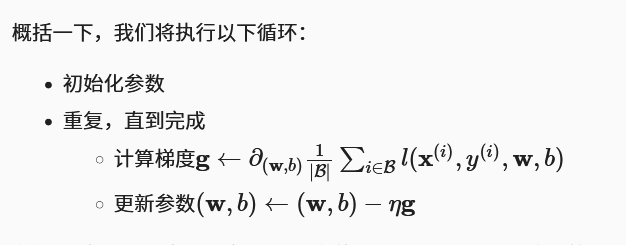

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        print(X,y)
        print(net(X,w,b))
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        #  l.sum().backward()
        l.sum().backward()
        print("l1",l)
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


tensor([[ 0.2013, -2.0954],
        [-1.8673, -0.8444],
        [ 0.7919, -0.7151],
        [ 1.5339, -1.8126],
        [-1.0154,  1.4221],
        [-0.5538,  0.4307],
        [-0.1846,  0.2838],
        [-0.9219,  1.5088],
        [-0.9093, -1.2022],
        [ 0.6037, -1.0768]]) tensor([[11.7318],
        [ 3.3331],
        [ 8.2128],
        [13.4189],
        [-2.6651],
        [ 1.6335],
        [ 2.8515],
        [-2.7851],
        [ 6.4873],
        [ 9.0661]])
tensor([[11.7263],
        [ 3.3348],
        [ 8.2154],
        [13.4310],
        [-2.6658],
        [ 1.6280],
        [ 2.8661],
        [-2.7733],
        [ 6.4678],
        [ 9.0685]], grad_fn=<AddBackward0>)
tensor([[1.5292e-05],
        [1.4199e-06],
        [3.3127e-06],
        [7.3196e-05],
        [3.0615e-07],
        [1.5070e-05],
        [1.0614e-04],
        [6.9519e-05],
        [1.9008e-04],
        [2.9616e-06]], grad_fn=<DivBackward0>)
l1 tensor([[1.5292e-05],
        [1.4199e-06],
        [3.3127e-06],

tensor([[0.0301],
        [0.0542]])
tensor([4.2001], requires_grad=True)
tensor([-0.0013])
tensor([[-0.3145, -0.1786],
        [ 0.9099,  0.4175],
        [ 0.3658, -0.7213],
        [-1.3079,  0.5873],
        [-0.4937, -0.3237],
        [ 0.6578, -0.7670],
        [ 1.6242,  1.0363],
        [-1.3337, -0.1780],
        [ 0.0046,  0.3055],
        [-0.8314, -0.0785]]) tensor([[ 4.1742],
        [ 4.6060],
        [ 7.3833],
        [-0.4202],
        [ 4.3306],
        [ 8.1252],
        [ 3.9076],
        [ 2.1299],
        [ 3.1815],
        [ 2.8043]])
tensor([[ 4.1781],
        [ 4.6008],
        [ 7.3842],
        [-0.4130],
        [ 4.3131],
        [ 8.1238],
        [ 3.9261],
        [ 2.1373],
        [ 3.1707],
        [ 2.8038]], grad_fn=<AddBackward0>)
tensor([[7.5848e-06],
        [1.3403e-05],
        [4.2479e-07],
        [2.5850e-05],
        [1.5363e-04],
        [9.4296e-07],
        [1.7232e-04],
        [2.6881e-05],
        [5.8211e-05],
        [9.8011e-08]], 

tensor([[-4.1794],
        [ 0.2148],
        [ 0.8203],
        [ 7.0606],
        [ 9.3470],
        [ 2.0121],
        [-0.1051],
        [ 6.8539],
        [10.4598],
        [ 0.7259]], grad_fn=<AddBackward0>)
tensor([[6.3778e-06],
        [1.5058e-04],
        [1.4092e-05],
        [1.3822e-04],
        [7.9957e-07],
        [1.0900e-05],
        [3.2087e-05],
        [5.9806e-06],
        [2.6197e-07],
        [9.0847e-06]], grad_fn=<DivBackward0>)
l1 tensor([[6.3778e-06],
        [1.5058e-04],
        [1.4092e-05],
        [1.3822e-04],
        [7.9957e-07],
        [1.0900e-05],
        [3.2087e-05],
        [5.9806e-06],
        [2.6197e-07],
        [9.0847e-06]], grad_fn=<DivBackward0>)
tensor([[ 2.0005],
        [-3.3999]], requires_grad=True)
tensor([[-0.0240],
        [ 0.0374]])
tensor([4.2003], requires_grad=True)
tensor([0.0051])
tensor([[-0.1707, -0.2465],
        [-0.8562, -0.1381],
        [ 0.1303,  1.4978],
        [-0.2395, -0.1958],
        [ 0.7094,  0.0839],


tensor([[1.0709e-06],
        [2.2311e-05],
        [1.7912e-05],
        [3.5767e-06],
        [2.2070e-05],
        [2.7523e-05],
        [2.8398e-04],
        [6.9718e-06],
        [1.1345e-06],
        [3.4936e-07]], grad_fn=<DivBackward0>)
l1 tensor([[1.0709e-06],
        [2.2311e-05],
        [1.7912e-05],
        [3.5767e-06],
        [2.2070e-05],
        [2.7523e-05],
        [2.8398e-04],
        [6.9718e-06],
        [1.1345e-06],
        [3.4936e-07]], grad_fn=<DivBackward0>)
tensor([[ 2.0006],
        [-3.4002]], requires_grad=True)
tensor([[ 0.0039],
        [-0.0041]])
tensor([4.2002], requires_grad=True)
tensor([-0.0244])
tensor([[ 0.2339,  0.7636],
        [ 1.1170,  0.8877],
        [ 1.1224, -1.2660],
        [ 1.2221,  0.0678],
        [ 0.1869,  1.6555],
        [-1.3553,  0.0445],
        [ 0.0485, -0.5496],
        [ 1.4861, -1.6857],
        [ 1.0121,  1.2817],
        [ 1.2496, -2.1679]]) tensor([[ 2.0682],
        [ 3.4280],
        [10.7488],
        [ 6.4275

tensor([[8.4893e-05],
        [1.3449e-06],
        [1.3142e-08],
        [2.8764e-08],
        [6.4530e-06],
        [1.7326e-05],
        [1.4048e-04],
        [1.3248e-04],
        [1.8971e-06],
        [1.4195e-04]], grad_fn=<DivBackward0>)
l1 tensor([[8.4893e-05],
        [1.3449e-06],
        [1.3142e-08],
        [2.8764e-08],
        [6.4530e-06],
        [1.7326e-05],
        [1.4048e-04],
        [1.3248e-04],
        [1.8971e-06],
        [1.4195e-04]], grad_fn=<DivBackward0>)
tensor([[ 2.0005],
        [-3.4002]], requires_grad=True)
tensor([[0.0712],
        [0.0006]])
tensor([4.2007], requires_grad=True)
tensor([-0.0650])
tensor([[-0.4761,  0.9102],
        [ 0.0844, -0.2714],
        [ 1.7980,  0.3248],
        [ 1.2110, -0.8838],
        [ 0.8723, -0.7124],
        [ 0.7860, -0.2058],
        [-0.5852, -0.1505],
        [-1.0950, -0.4733],
        [ 0.2267, -0.1094],
        [ 0.5913, -1.2593]]) tensor([[0.1644],
        [5.2807],
        [6.6864],
        [9.6334],
   

tensor([[ 8.0201],
        [-3.4677],
        [ 3.7416],
        [ 4.3309],
        [-3.9092],
        [-1.8090],
        [-0.4780],
        [ 7.5723],
        [ 6.3889],
        [ 4.6654]], grad_fn=<AddBackward0>)
tensor([[1.2850e-06],
        [1.0797e-04],
        [2.5488e-05],
        [9.2558e-06],
        [3.8972e-07],
        [2.0654e-05],
        [4.0249e-05],
        [1.2994e-05],
        [7.6888e-05],
        [2.2111e-05]], grad_fn=<DivBackward0>)
l1 tensor([[1.2850e-06],
        [1.0797e-04],
        [2.5488e-05],
        [9.2558e-06],
        [3.8972e-07],
        [2.0654e-05],
        [4.0249e-05],
        [1.2994e-05],
        [7.6888e-05],
        [2.2111e-05]], grad_fn=<DivBackward0>)
tensor([[ 2.0010],
        [-3.3998]], requires_grad=True)
tensor([[ 0.0392],
        [-0.0187]])
tensor([4.2005], requires_grad=True)
tensor([-0.0403])
tensor([[-1.1582,  0.2053],
        [-0.9979, -0.4964],
        [ 2.4388, -0.4199],
        [-0.4795,  0.5943],
        [ 1.9867,  0.1806],

        [-0.0272, -1.4884]]) tensor([[ 7.9126],
        [ 6.7096],
        [10.0765],
        [ 7.0773],
        [-1.9188],
        [-1.6781],
        [ 0.0300],
        [ 9.0928],
        [ 8.5211],
        [ 9.2156]])
tensor([[ 7.8892],
        [ 6.7176],
        [10.0841],
        [ 7.0606],
        [-1.9105],
        [-1.6689],
        [ 0.0228],
        [ 9.0911],
        [ 8.5204],
        [ 9.2062]], grad_fn=<AddBackward0>)
tensor([[2.7387e-04],
        [3.2121e-05],
        [2.9344e-05],
        [1.3844e-04],
        [3.3987e-05],
        [4.2195e-05],
        [2.6056e-05],
        [1.4882e-06],
        [2.0658e-07],
        [4.4858e-05]], grad_fn=<DivBackward0>)
l1 tensor([[2.7387e-04],
        [3.2121e-05],
        [2.9344e-05],
        [1.3844e-04],
        [3.3987e-05],
        [4.2195e-05],
        [2.6056e-05],
        [1.4882e-06],
        [2.0658e-07],
        [4.4858e-05]], grad_fn=<DivBackward0>)
tensor([[ 2.0006],
        [-3.3999]], requires_grad=True)
tensor([[-0.0

tensor([[ 0.0035],
        [-0.0363]])
tensor([4.2002], requires_grad=True)
tensor([-0.0056])
tensor([[-1.7178,  0.5806],
        [ 0.7850,  0.2513],
        [ 0.4696,  0.9769],
        [-0.7540,  0.6971],
        [-0.8872,  0.9703],
        [ 0.0485, -0.5496],
        [ 0.2261, -0.6066],
        [ 0.4103, -0.9063],
        [-1.2226,  0.0830],
        [-1.0966,  0.4100]]) tensor([[-1.2095],
        [ 4.9233],
        [ 1.8019],
        [ 0.3270],
        [-0.8876],
        [ 6.1440],
        [ 6.7133],
        [ 8.0955],
        [ 1.4650],
        [ 0.6141]])
tensor([[-1.2092],
        [ 4.9157],
        [ 1.8181],
        [ 0.3223],
        [-0.8730],
        [ 6.1658],
        [ 6.7149],
        [ 8.1019],
        [ 1.4729],
        [ 0.6134]], grad_fn=<AddBackward0>)
tensor([[5.2801e-08],
        [2.8291e-05],
        [1.3180e-04],
        [1.0858e-05],
        [1.0628e-04],
        [2.3722e-04],
        [1.2471e-06],
        [2.0268e-05],
        [3.1573e-05],
        [2.9063e-07]]

tensor([[-0.4937, -0.3237],
        [ 0.2150,  1.9457],
        [-0.4778,  1.2414],
        [ 0.1826,  0.7801],
        [ 0.3422, -0.2419],
        [-0.1878,  0.0557],
        [ 0.6269, -0.3891],
        [-1.6488, -1.7237],
        [-1.1499, -0.6878],
        [-1.1016, -0.9212]]) tensor([[ 4.3306],
        [-1.9674],
        [-0.9780],
        [ 1.9172],
        [ 5.7008],
        [ 3.6365],
        [ 6.7860],
        [ 6.7649],
        [ 4.2365],
        [ 5.1193]])
tensor([[ 4.3134],
        [-1.9847],
        [-0.9757],
        [ 1.9134],
        [ 5.7073],
        [ 3.6351],
        [ 6.7768],
        [ 6.7626],
        [ 4.2386],
        [ 5.1287]], grad_fn=<AddBackward0>)
tensor([[1.4793e-04],
        [1.4989e-04],
        [2.5104e-06],
        [7.3773e-06],
        [2.0732e-05],
        [9.7133e-07],
        [4.2102e-05],
        [2.7553e-06],
        [2.2060e-06],
        [4.4067e-05]], grad_fn=<DivBackward0>)
l1 tensor([[1.4793e-04],
        [1.4989e-04],
        [2.5104e-06],

tensor([[ 0.6054, -0.4424],
        [-0.1581,  0.8347],
        [ 1.3755, -0.7044],
        [-0.2236,  1.3723],
        [-1.5065,  1.2637],
        [ 0.2001,  1.9850],
        [-1.0485, -1.3867],
        [ 0.0180, -0.1602],
        [-0.1846,  0.2838],
        [ 1.2011, -1.4530]]) tensor([[ 6.9185],
        [ 1.0469],
        [ 9.3483],
        [-0.9124],
        [-3.0983],
        [-2.1414],
        [ 6.8227],
        [ 4.7768],
        [ 2.8515],
        [11.5439]])
tensor([[ 6.9158],
        [ 1.0466],
        [ 9.3469],
        [-0.9122],
        [-3.1090],
        [-2.1480],
        [ 6.8184],
        [ 4.7813],
        [ 2.8665],
        [11.5434]], grad_fn=<AddBackward0>)
tensor([[3.8495e-06],
        [7.1402e-08],
        [9.8266e-07],
        [2.3601e-08],
        [5.6436e-05],
        [2.1834e-05],
        [9.3421e-06],
        [1.0069e-05],
        [1.1189e-04],
        [1.6866e-07]], grad_fn=<DivBackward0>)
l1 tensor([[3.8495e-06],
        [7.1402e-08],
        [9.8266e-07],

In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')


w的估计误差: tensor([-0.0007, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0002], grad_fn=<RsubBackward1>)


## 3.2.8 小结

我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。

这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。


## 3.2.9 练习

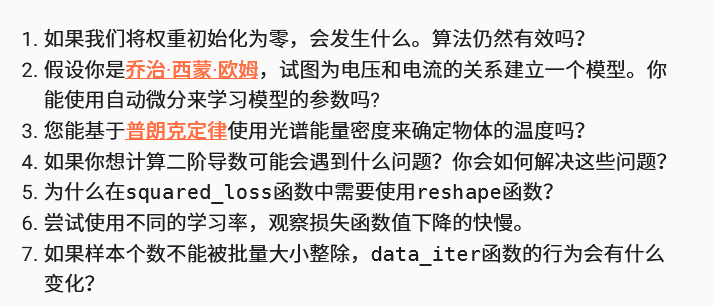